# 1.Business Understanding


# 2.Data Understanding

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

import warnings 
warnings.filterwarnings('ignore')

from sklearn.utils import class_weight

from sklearn.preprocessing import StandardScaler,PowerTransformer,OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,balanced_accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix

import pickle

In [7]:
df = pd.read_csv('/home/yash/Desktop/Project/Predictve_Maintenance_Project/datasets/failures_data.csv')

In [8]:
data_duplicates = df.duplicated().sum()
print("Total duplicated values:",data_duplicates)

Total duplicated values: 0


In [9]:
data_null = df.isnull().sum().sum()
print("Total missing values:",data_null)

Total missing values: 0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [11]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [12]:
df.Target.value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

In [13]:
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

# Data Preparation

In [14]:
rename_columns = {
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'    
}
df.rename(rename_columns,axis=1,inplace=True)

In [15]:
count_failures = (df['Target']==1).sum()
print('Number of failures:',count_failures)

sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Sum of failures different of "No Failure":', sum_failures)

Number of failures: 339
Sum of failures different of "No Failure": 330


In [16]:
rows_to_remove = df[(df['Target']==1)& (df['Failure_type']=='No Failure')]
df.drop(rows_to_remove.index,inplace = True)

In [17]:
drop_columns = ["ID", "Product_ID", "Target"]
df.drop(drop_columns, axis = 1, inplace = True)

In [18]:
df = df.loc[df['Failure_type']!='Random Failures']

In [19]:
rename_type = {
    'L':'Low',
    'M':'Medium',
    'H':'High'
}
df['Type'].replace(rename_type, inplace = True)

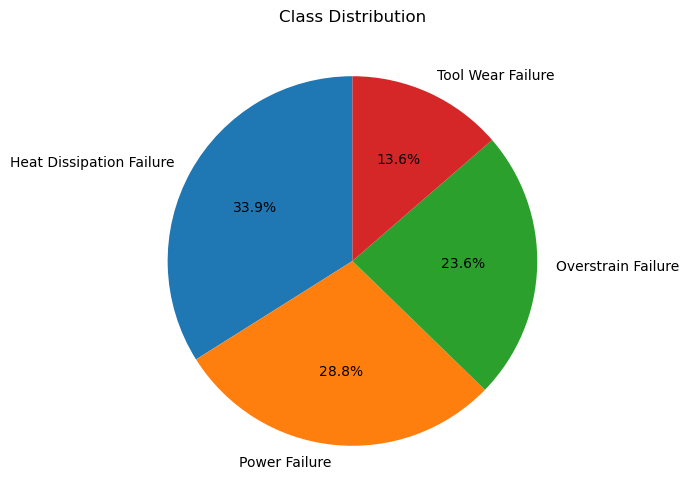

In [20]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]

proportions = df_failure_type['Failure_type'].value_counts(normalize = True)

plt.figure(figsize = (8,6))

plt.pie(proportions,labels = proportions.index,autopct='%1.1f%%',startangle =90)

plt.title("Class Distribution")
plt.show()

In [21]:
NUMERIC_FEATURES = ['Air_temperature','Process_temperature','Rotational_speed','Torque','Tool_wear']
CATEGORIC_FEATURES = ['Type']

<Axes: >

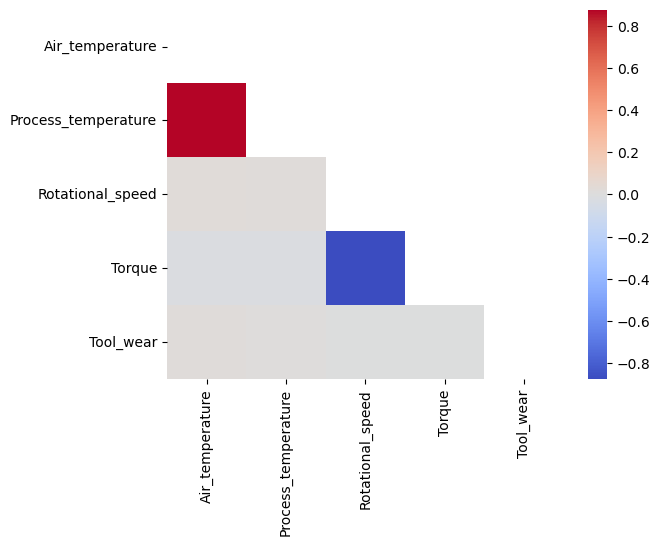

In [31]:
corr = df[NUMERIC_FEATURES].corr()
mask = np.triu(np.ones_like(corr,dtype = bool))
sb.heatmap(corr,annot = True,mask = mask,cmap = 'coolwarm')

In [32]:
num_pipeline = Pipeline([
    ('num_features',StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_features',OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num_trans',num_pipeline,NUMERIC_FEATURES),
    ('cat_trans',cat_pipeline,CATEGORIC_FEATURES)
])

df_transformed = preprocessor.fit_transform(df)

encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)

new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)

df_transformed = pd.DataFrame(df_transformed,columns = new_column_names)

df_transformed.head(10)


,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0
5,-0.951417,-0.946356,-0.634845,0.192750,-1.522816,0.0,0.0,1.0
6,-0.951417,-0.946356,0.106502,0.242919,-1.475680,0.0,1.0,0.0
7,-0.951417,-0.946356,-0.066293,0.022175,-1.444256,0.0,1.0,0.0
8,-0.851439,-0.878954,0.714072,-1.141746,-1.412833,0.0,0.0,1.0
9,-0.751461,-0.676745,1.126551,-1.201949,-1.365697,0.0,0.0,1.0


# 4.Modelling



In [127]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES+CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [128]:
from sklearn.metrics import f1_score
def get_metrics(y_true, y_pred):
    f1_scores_per_class = f1_score(y_true, y_pred, average=None)
    
    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro'),
        'F1 Scores per Class': f1_scores_per_class
    }
    return dict_metrics

In [129]:
pip_model= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=2023))
])

# Fit pipeline with sample weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
pip_model.fit(X_train, y_train, model__sample_weight=weights)


y_pred = pip_model.predict(X_test)


metrics = get_metrics(y_test, y_pred)


metrics

{'Accuracy': 0.9789473684210527,
 'Balanced Accuracy': 0.45767143895366863,
 'Macro Recall': 0.45767143895366863,
 'Macro Precision': 0.780450834082119,
 'Macro F1': 0.5517711226690191,
 'F1 Scores per Class': array([0.68571429, 0.98922524, 0.54545455, 0.53846154, 0.        ])}

In [132]:
with open('/home/yash/Desktop/ml_projects/Predictive_Maintenance_Project/model/model.pkl','wb') as model_file:
    pickle.dump(pip_model,model_file)